## DDQN
### 算法定义

DQN的一个问题在于，DQN中的Q网络很容易对动作得到的真实的Q值进行高估，如图

![](https://datawhalechina.github.io/easy-rl/img/ch7/7.1.png)

原因在于，每次从Q网络中选择动作时都是选择Q值最大的动作，而Q网络对Q值的估计是有偏差的，选择Q值最大的动作更有可能选到估计的偏差为比真实的Q值高的动作。假设有5个学生，他们的真实能力都是80分。现在你作为老师，对他们进行5次不完美的评估（就像Q网络的估计），评估结果会有一些随机误差：

学生A：评估为 80 + 2 = 82分
学生B：评估为 80 - 3 = 77分
学生C：评估为 80 + 5 = 85分
学生D：评估为 80 - 1 = 79分
学生E：评估为 80 + 1 = 81分

当进行 max 操作时，选择的是学生C的85分。这个评估出的最大值 (85分) 大于真实的最佳值 (80分)。因此使用 max 操作很可能会高估，那同样，在使用 min 操作的地方很可能会低估。

如何解决这个问题呢，可以将选择动作的网络和打分的网络分开，不要让一个网络自己又选最好的动作又自己给这个动作打分，原本的用一个网络的方法相当于让学生自己选自己觉得最好的解法同时还给自己的解法打分，现在只让他选自己觉得最好的解法，打分由别人来做，这样就减少了给他的解法打分过高的问题，除非两个网络同时都出现了同方向的偏差，这种可能性当然还存在，只是相比只用一个网络时大大降低了可能性。


DDQN和DQN的主要区别在于，DQN中目标网络既用于选择动作，也用于计算动作对应的Q值，但在DDQN中，用策略网络来选择动作，动作对应Q值的计算交给目标网络去做。因此主要修改在核心算法部分，将next_q_values的计算从直接用目标网络改为使用策略网络选择动作，用目标网络来计算。 

**----------注意--------------**

此处修改的计算Q值的地方是下一个状态的Q值估计部分，即

$$
y_i = 
\begin{cases} 
r_i & \text{对于终止状态 } s_{i+1} \\
r_i + \gamma \max_{a'} Q(s_{i+1}, a'; \theta) & \text{对于非终止状态 } s_{i+1}
\end{cases}
$$

这一部分中的下一个状态的Q值估计，在当前状态和选择动作及下一个状态均已知的情况下，需要在对下一个状态Q值的估计中使用两个网络来估计更真实的Q值，注意这里不是用目标网络来估计当前状态下已经选择好的动作的Q值，因为这样我们就不能优化策略网络了，当前状态下已经选好的动作是策略网络选择出来的，我们要根据他的选择和他的Q值估计与目标Q值之间的差距来优化这个策略网络，如果此处使用目标网络去评估策略网络选择出来的动作的Q值，就没办法通过梯度下降来优化策略网络了。

## 1.1 定义模型
前面说了DQN的模型不再是Q表，而是一个深度神经网络，这里我只用了一个三层的全连接网络（FCN），这种网络也叫多层感知机（MLP），至于怎么用Torch写网络这里就不多说明了，以下仅供参考。

In [1]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self, n_states,n_actions,hidden_dim=128):
        """ 初始化q网络，为全连接网络
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_states, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim * 2) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim) 
        self.fc4 = nn.Linear(hidden_dim, n_actions) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

## 1.2 定义经验回放
与DQN相同

In [2]:
from collections import deque
import random
class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放,append在队列库的实现中是右侧放入,队列满的时候左侧的元素会被自动弹出，形成FIFO
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 随机开始位置的顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

## 1.3 真·算法
主要改动在这个地方，将原本的直接使用target_net计算Q值的方式改为使用policy_net选择动作，使用target_net计算Q值，一定注意改动的是对下一状态的Q的计算而不是当前状态。


In [10]:
import torch
import torch.optim as optim
import math
import numpy as np
import copy
class DQN:
    def __init__(self,model,memory,cfg):

        self.n_actions = cfg['n_actions']  
        self.device = torch.device(cfg['device']) 
        self.gamma = cfg['gamma'] # 奖励的折扣因子
        # e-greedy策略相关参数 这里
        self.sample_count = 0  # 用于epsilon的衰减计数
        self.epsilon = cfg['epsilon_start']
        self.sample_count = 0  
        self.epsilon_start = cfg['epsilon_start']
        self.epsilon_end = cfg['epsilon_end']
        self.epsilon_decay = cfg['epsilon_decay']
        self.batch_size = cfg['batch_size']
        self.policy_net = model.to(self.device)
        # 这里改用深拷贝创建一个新的独立网络并拥有自己独立的内存空间 
        self.target_net = copy.deepcopy(self.policy_net)
        # 原始代码，有指向同一个实例化模型的嫌疑，这里为了保险改用深拷贝
        # self.target_net = model.to(self.device)
        # 复制参数到目标网络
        # for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): 
            #target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg['lr']) # 优化器
        self.memory = memory # 经验回放
    def sample_action(self, state):
        ''' 采样动作
        '''
        self.sample_count += 1
        # epsilon指数衰减
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if random.random() > self.epsilon:
            return self.predict_action(state)
        else:
            return random.randrange(self.n_actions)
    @torch.no_grad() # 不计算梯度，该装饰器效果等同于with torch.no_grad()： 这里仅仅是采样，是运行一下策略网络，不是来优化策略网络的，所以不要计算梯度
    def predict_action(self, state):
        ''' 预测动作
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        q_values = self.policy_net(state)
        action = q_values.max(1)[1].item() # choose action corresponding to the maximum q value
        return action
    def update(self):
        if len(self.memory) < self.batch_size: # 当经验回放中不满足一个批量时，不更新策略
            return
        # 从经验回放中随机采样一个批量的转移(transition) 注意此处对应着标准的四元组 加上一个done表示某一步采样是否正好结束状态
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        # 将数据转换为tensor
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)  # 转换成state一样的形状 不然就是一维的batch batch每个样本对应的动作
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float).unsqueeze(1) 
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device).unsqueeze(1)
        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch) # 计算当前状态(s_t,a)对应的Q(s_t, a)
        # 改动在这个部分！！！！
        next_q_value_policy = self.policy_net(next_state_batch) # 下一个状态对应的实际策略网络Q值
        next_q_value_target = self.target_net(next_state_batch) # 下一个状态对应的目标网络Q值
        # 将策略网络Q值最大的动作对应的目标网络Q值作为期望的Q值
        next_target_q_value_batch = next_q_value_target.gather(1, torch.max(next_q_value_policy, 1)[1].unsqueeze(1))
        # 计算期望的Q值，对于终止状态，此时done_batch[0]=1, 对应的expected_q_value等于reward
        expected_q_values = reward_batch + self.gamma * next_target_q_value_batch * (1-done_batch)
        loss = nn.MSELoss()(q_values, expected_q_values)  # 计算均方根损失
        # 优化更新模型
        self.optimizer.zero_grad()  
        loss.backward()
        # clip防止梯度爆炸
        for param in self.policy_net.parameters():  
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 

## 2 定义训练

适配了新版的api（如seed的传入位置，reset的新返回值和step的新返回值），增加了测试时的录制功能，会录制一个视频来记录测试过程 

In [4]:
from gymnasium.wrappers import RecordVideo
from IPython.display import Video, display
import glob
import gymnasium as gym
import os

def train(cfg, env, agent):
    print("开始训练！")
    rewards = []
    steps = []

    # 设置动作空间seed
    if cfg.get('seed', None) is not None:
        env.action_space.seed(cfg['seed'])
        
    for i_ep in range(cfg['train_eps']):
        ep_reward = 0.0
        ep_step = 0
        # Gymnasium 的 reset 返回 (obs, info) 并在此处加入seed参数
        state, _ = env.reset(seed=cfg.get('seed', None))
        for _ in range(cfg['ep_max_steps']):
            ep_step += 1
            action = agent.sample_action(state)
            # Gymnasium 的 step 返回 5 元组
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.memory.push((state, action, reward, next_state, done))
            state = next_state
            agent.update()
            ep_reward += reward
            if done:
                break

        if (i_ep + 1) % cfg['target_update'] == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg['train_eps']}，奖励：{ep_reward:.2f}，Epislon：{agent.epsilon:.3f}")

    print("完成训练！")
    env.close()
    return {'rewards': rewards}

# 增加了录制最终测试时的场景视频并播放的功能
def test_and_record(cfg, agent, video_dir='./videos', name_prefix='dqn-test'):
    os.makedirs(video_dir, exist_ok=True)
    # 仅用于录制的环境：必须用 rgb_array
    env = gym.make(cfg['env_name'], render_mode='rgb_array')
    # 可选：设置随机种子
    seed = cfg.get('seed', None)
    if seed is not None:
        env.action_space.seed(seed)
    # 只录制最后一集
    env = RecordVideo(
        env,
        video_folder=video_dir,
        name_prefix=name_prefix,
        episode_trigger=lambda ep_id: ep_id == cfg['test_eps'] - 1
    )
    print("开始测试并录制视频！")
    rewards = []
    for i_ep in range(cfg['test_eps']):
        state, _ = env.reset(seed=seed)
        ep_reward = 0.0
        for _ in range(cfg['ep_max_steps']):
            action = agent.predict_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_reward += reward
            state = next_state
            if terminated or truncated:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg['test_eps']}，奖励：{ep_reward:.2f}")
    env.close()
    print("完成测试与录制")
    # 只查找本次 name_prefix 下的 mp4，避免历史文件干扰
    mp4s = sorted(glob.glob(os.path.join(video_dir, f'{name_prefix}*.mp4')))
    if mp4s:
        print(f"视频文件：{mp4s[-1]}")
        display(Video(mp4s[-1], embed=True))
    else:
        print(f"未找到视频文件，请检查目录：{video_dir} 或确认已安装 imageio 和 imageio-ffmpeg")
    return {'rewards': rewards, 'video_path': (mp4s[-1] if mp4s else None)}


## 3 定义环境
此处因为gym包更新为gymnasium，因此需要对之前使用gym包环境定义进行一些改动

In [5]:
import gymnasium as gym
import os
# 让所有的随机种子都使用同一个数
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    # 新版已经舍弃 env.seed 需要在env.reset还有env.observation_space和action_space中单独传入seed参数
    # env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn 不用也可以 这里是保证100%可复现
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg['env_name']) # 创建环境
    if cfg['seed'] !=0:
        all_seed(env,seed=cfg['seed'])
    n_states = env.observation_space.shape[0]
    # 注意 属性n在离散动作空间的情况下才有 连续动作空间没有这个属性
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    cfg.update({"n_states":n_states,"n_actions":n_actions}) # 更新n_states和n_actions到cfg参数中
    model = MLP(n_states, n_actions, hidden_dim = cfg['hidden_dim']) # 创建模型
    memory = ReplayBuffer(cfg['memory_capacity'])
    agent = DQN(model,memory,cfg)
    return env,agent

## 4 设置参数

In [15]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
def get_args():
    """ 超参数 可以自己调整超参数或使用不同的网络结构玩一下 
    """
    parser = argparse.ArgumentParser(description="hyperparameters")      
    parser.add_argument('--algo_name',default='DQN',type=str,help="name of algorithm")
    # 注意 新版gym中 改为了CartPole-v1 v0已经弃用
    parser.add_argument('--env_name',default='CartPole-v1',type=str,help="name of environment")
    parser.add_argument('--train_eps',default=90,type=int,help="episodes of training")
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing")
    parser.add_argument('--ep_max_steps',default = 100000,type=int,help="steps per episode, much larger value can simulate infinite steps")
    parser.add_argument('--gamma',default=0.95,type=float,help="discounted factor")
    parser.add_argument('--epsilon_start',default=0.95,type=float,help="initial value of epsilon")
    parser.add_argument('--epsilon_end',default=0.01,type=float,help="final value of epsilon")
    parser.add_argument('--epsilon_decay',default=500,type=int,help="decay rate of epsilon, the higher value, the slower decay")
    parser.add_argument('--lr',default=0.0001,type=float,help="learning rate")
    parser.add_argument('--memory_capacity',default=100000,type=int,help="memory capacity")
    parser.add_argument('--batch_size',default=64,type=int)
    parser.add_argument('--target_update',default=4,type=int)
    parser.add_argument('--hidden_dim',default=256,type=int)
    parser.add_argument('--device',default='cuda',type=str,help="cpu or cuda") 
    parser.add_argument('--seed',default=10,type=int,help="seed")   
    args = parser.parse_args([])
    args = {**vars(args)}  # 转换成字典类型    
    ## 打印超参数
    print("超参数")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in args.items():
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))      
    return args
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg['device']} of {cfg['algo_name']} for {cfg['env_name']}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()

## 5 开始训练

超参数
        Name        	       Value        	        Type        
     algo_name      	        DQN         	   <class 'str'>    
      env_name      	    CartPole-v1     	   <class 'str'>    
     train_eps      	         90         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
    ep_max_steps    	       100000       	   <class 'int'>    
       gamma        	        0.95        	  <class 'float'>   
   epsilon_start    	        0.95        	  <class 'float'>   
    epsilon_end     	        0.01        	  <class 'float'>   
   epsilon_decay    	        500         	   <class 'int'>    
         lr         	       0.0001       	  <class 'float'>   
  memory_capacity   	       100000       	   <class 'int'>    
     batch_size     	         64         	   <class 'int'>    
   target_update    	         4          	   <class 'int'>    
     hidden_dim     	        256         	   <class 'int'>    
       device       	        cuda        	   <class

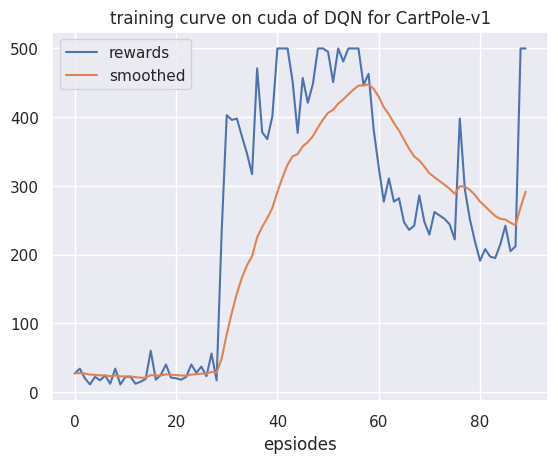

开始测试并录制视频！
回合：1/20，奖励：229.00
回合：2/20，奖励：229.00
回合：3/20，奖励：229.00


/root/shared-nvme/RL_learn/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /root/shared-nvme/RL_learn/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


回合：4/20，奖励：229.00
回合：5/20，奖励：229.00
回合：6/20，奖励：229.00
回合：7/20，奖励：229.00
回合：8/20，奖励：229.00
回合：9/20，奖励：229.00
回合：10/20，奖励：229.00
回合：11/20，奖励：229.00
回合：12/20，奖励：229.00
回合：13/20，奖励：229.00
回合：14/20，奖励：229.00
回合：15/20，奖励：229.00
回合：16/20，奖励：229.00
回合：17/20，奖励：229.00
回合：18/20，奖励：229.00
回合：19/20，奖励：229.00


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM default


回合：20/20，奖励：229.00
完成测试与录制
视频文件：./videos/ddqn-test-episode-19.mp4


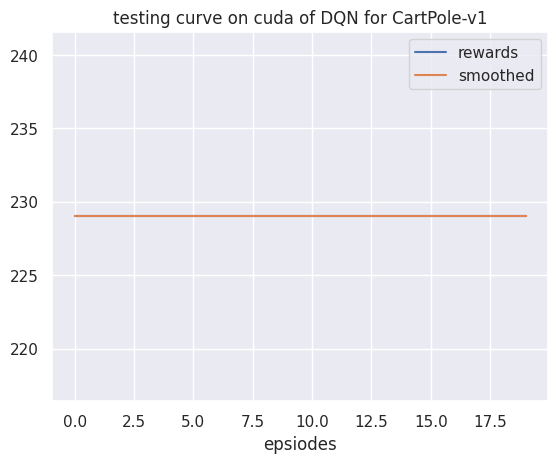

In [16]:
# 获取参数
cfg = get_args() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test_and_record(cfg, agent, name_prefix="ddqn-test")
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果